In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/bert

Mounted at /content/gdrive
/content/gdrive/MyDrive/bert


In [3]:
%%capture
!pip install transformers

In [4]:
import re
import os

import numpy as np
import pandas as pd
import torch
from sklearn import metrics
import matplotlib.pyplot as plt

from transformers import BertTokenizer
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from transformers import TFBertModel

from preprocess_data import read_dublin_data, read_sentiment_data
from bert_model import bert_encode, create_model
from evaluate import plot_learning_curves, evaluate_model

In [5]:
BATCH_SIZE = 32
NEURONS_HIDDEN = 64
LEARNING_RATE_MODEL = 1e-6
EPOCHS = 10
N_SAMPLE = 10000

In [6]:
%%capture
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

In [7]:
%%capture
filename = "/content/gdrive/MyDrive/bert/Sentiment140-train.csv"
df = read_sentiment_data(filename)
df = df.sample(N_SAMPLE, random_state=1).reset_index(drop=True)

le = LabelEncoder()
le.fit(df['sentiment'])

df['target_encoded'] = le.transform(df['sentiment'])

texts = df['text']
target_train = df['target_encoded']

train_input_ids, train_attention_masks = bert_encode(texts, 128, tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [8]:
%%capture
filename = "/content/gdrive/MyDrive/bert/Sentiment140-test.csv"

df_test = read_sentiment_data(filename)
df_test['target_encoded'] = le.transform(df_test['sentiment'])

texts = df_test['text']
target_test = df_test['target_encoded']

test_input_ids, test_attention_masks = bert_encode(texts, 128, tokenizer)


In [9]:
%%capture
filename = "/content/gdrive/MyDrive/bert/citypulse.dublin_city_council.test.csv"

df_dublin = read_dublin_data(filename)

df_dublin['target_encoded'] = le.transform(df_dublin['sentiment'])
texts = df_dublin['text']
target_dublin = df_dublin['target_encoded']

dublin_input_ids, dublin_attention_masks = bert_encode(texts, 128, tokenizer)

In [10]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [11]:
model = create_model(bert_model, LEARNING_RATE_MODEL, NEURONS_HIDDEN)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           49216       tf_bert_model[0][1]          

In [13]:
history = model.fit(
    [train_input_ids, train_attention_masks],
    target_train,
    validation_split=0.2, 
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/10
250/250 [==============================] - 218s 839ms/step - loss: 0.6835 - accuracy: 0.5624 - val_loss: 0.6348 - val_accuracy: 0.6835
Epoch 2/10
250/250 [==============================] - 210s 842ms/step - loss: 0.6144 - accuracy: 0.6710 - val_loss: 0.5202 - val_accuracy: 0.7650
Epoch 3/10
250/250 [==============================] - 210s 842ms/step - loss: 0.5144 - accuracy: 0.7635 - val_loss: 0.4512 - val_accuracy: 0.7990
Epoch 4/10
250/250 [==============================] - 207s 829ms/step - loss: 0.4712 - accuracy: 0.7894 - val_loss: 0.4338 - val_accuracy: 0.8085
Epoch 5/10
250/250 [==============================] - 209s 836ms/step - loss: 0.4480 - accuracy: 0.8054 - val_loss: 0.4217 - val_accuracy: 0.8135
Epoch 6/10
250/250 [==============================] - 211s 842ms/step - loss: 0.4167 - accuracy: 0.8202 - val_loss: 0.4158 - val_accuracy: 0.8175
Epoch 7/10
250/250 [==============================] - 209s 835ms/step - loss: 0.4020 - accuracy: 0.8286 - val_loss: 0.4144 -

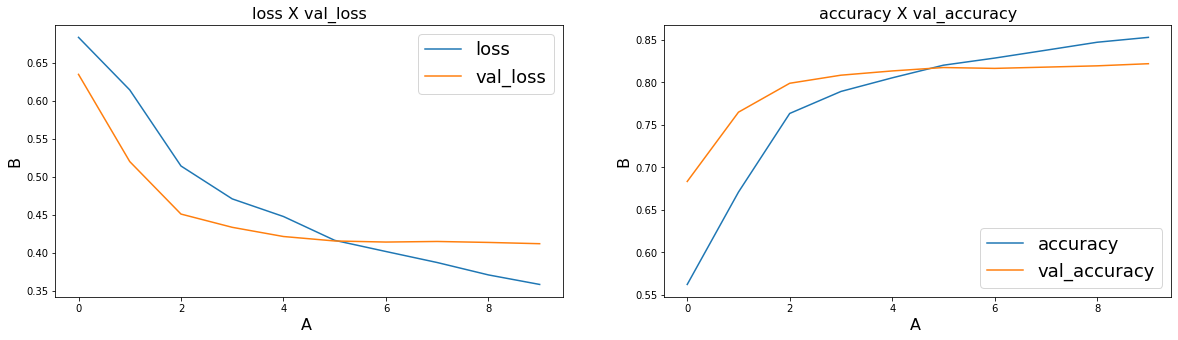

In [14]:
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [15]:
predictions_test = model.predict([test_input_ids, test_attention_masks])
predictions_test_class = [i.round() for i in predictions_test]

y_pred_bi = np.array(predictions_test_class)
y_hat_bi = np.array(df_test['sentiment'])
evaluate_model(y_hat_bi, y_pred_bi)

[[153  24]
 [ 26 156]]
              precision    recall  f1-score   support

           0       0.85      0.86      0.86       177
           1       0.87      0.86      0.86       182

    accuracy                           0.86       359
   macro avg       0.86      0.86      0.86       359
weighted avg       0.86      0.86      0.86       359

Accuracy Score: 0.861


In [20]:
predictions_dublin = model.predict([dublin_input_ids, dublin_attention_masks])
predictions_dublin_class = [i.round() for i in predictions_dublin]
df_dublin['sentiment_pred'] = predictions_dublin_class

y_pred_bi = np.array(predictions_dublin_class)
y_hat_bi = np.array(df_dublin['sentiment'])
evaluate_model(y_hat_bi, y_pred_bi)

[[762 238]
 [379 621]]
              precision    recall  f1-score   support

           0       0.67      0.76      0.71      1000
           1       0.72      0.62      0.67      1000

    accuracy                           0.69      2000
   macro avg       0.70      0.69      0.69      2000
weighted avg       0.70      0.69      0.69      2000

Accuracy Score: 0.692


In [17]:
predictions_train = model.predict([train_input_ids, train_attention_masks])
predictions_train_class = [i.round() for i in predictions_train]

y_pred_bi = np.array(predictions_train_class)
y_hat_bi = np.array(df['sentiment'])
evaluate_model(y_hat_bi, y_pred_bi)

[[4427  576]
 [ 682 4315]]
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      5003
           1       0.88      0.86      0.87      4997

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Accuracy Score: 0.874


In [24]:
df_dublin['sentiment_pred'] = df_dublin['sentiment_pred'].apply(lambda x: x[0])

In [25]:
for category in df_dublin['category'].unique():
    print(category)
    y_hat = df_dublin.loc[(df_dublin['sentiment']!=-1) & (df_dublin['category']!=category), "sentiment"]
    y_pred = df_dublin.loc[(df_dublin['sentiment']!=-1) & (df_dublin['category']!=category), "sentiment_pred"]
    evaluate_model(y_hat, y_pred)

Public Spaces
[[751 236]
 [379 613]]
              precision    recall  f1-score   support

           0       0.66      0.76      0.71       987
           1       0.72      0.62      0.67       992

    accuracy                           0.69      1979
   macro avg       0.69      0.69      0.69      1979
weighted avg       0.69      0.69      0.69      1979

Accuracy Score: 0.689
Community and Culture
[[674 184]
 [334 380]]
              precision    recall  f1-score   support

           0       0.67      0.79      0.72       858
           1       0.67      0.53      0.59       714

    accuracy                           0.67      1572
   macro avg       0.67      0.66      0.66      1572
weighted avg       0.67      0.67      0.66      1572

Accuracy Score: 0.670
Mobility
[[569 172]
 [288 527]]
              precision    recall  f1-score   support

           0       0.66      0.77      0.71       741
           1       0.75      0.65      0.70       815

    accuracy            